### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

/workspace/FLOOD_group2/models
/workspace/FLOOD_group2


In [2]:
import importlib
import torch
import joblib
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.optim.lr_scheduler import StepLR

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [17]:
# model save path
save_path = 'models/ConvLSTM_model/model_paths/augmentation_test_128hid_1lay_8batch.pth' 
#'models/ConvLSTM_model/model_paths/multiconv_lstm_32hid_2lay_3ker_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# apply augmentation
transformed_dataset = augmentation(train_dataset)

Inputs sizes: torch.Size([1, 4, 64, 64]),
Outputs sizes: torch.Size([48, 2, 64, 64])

rotate concat: <class 'torch.Tensor'>
The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 160


In [8]:
# Split dataset into train and validation
random_gen = torch.Generator().manual_seed(42) # find a random seed and fix it to always have the same split

train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size], random_gen)

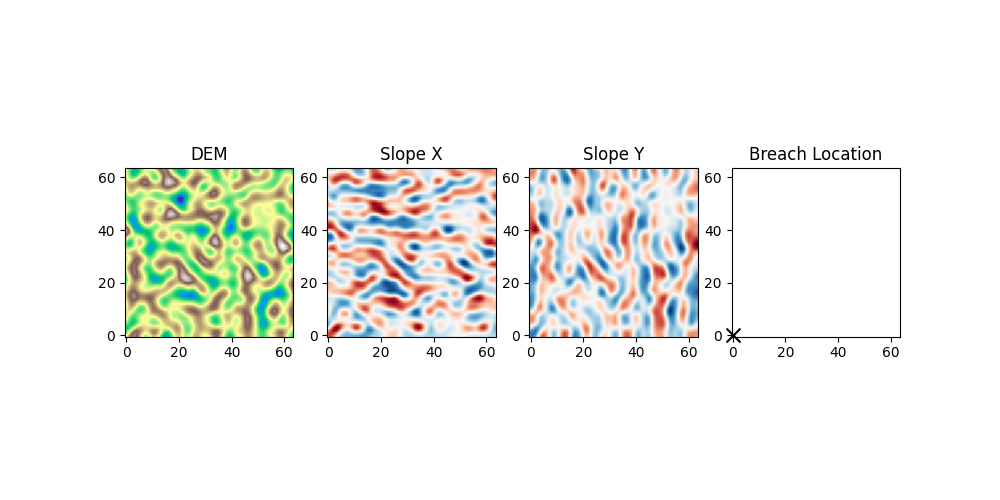

In [9]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 20
inputs = train_set[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_y = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_y, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_y, train_val)

In [11]:
## save scalers for use in seperate notebooks on testing, should not change unless seed is changed
joblib.dump(scaler_x, 'models/ConvLSTM_model/scalers/scaler_x.joblib')
joblib.dump(scaler_y, 'models/ConvLSTM_model/scalers/scaler_y.joblib');

In [18]:
# Model
model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1],
                          output_dim = normalized_train_dataset[0][1].shape[1], 
                          hidden_dim = 128, kernel_size = (5, 5), num_layers = 1,
                          batch_first=True, bias=True, return_all_layers = False).to(device)

# model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
#                  num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [19]:
model

MultiStepConvLSTM(
  (conv2): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(132, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [20]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # Assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 1690370
Model size: 6.45 MB


In [21]:
# Set training parameters
learning_rate = 0.01
batch_size = 8
num_epochs = 1_500

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create scheduler for decreasing the learning rate every 100 epochs with a factor 0.5
scheduler = StepLR(optimizer, step_size = 50, gamma = 0.1)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    scheduler.step() # update the learning rate
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device, loss_f = 'MSE')

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device, loss_f = 'MSE')

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    
    if epoch%5 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
        print(f'Current learning rate: {scheduler.get_last_lr()[0]}')
    stop_count = 100
    if count > stop_count:
        print(f"Loss Stagnated for {stop_count} epochs, early stopping initiated")
        break

Epoch: 5 	 Training loss:  3.73e-03 	 Validation loss:  3.11e-03 	 Best validation loss:  3.11e-03
Current learning rate: 0.01
Epoch: 10 	 Training loss:  3.28e-03 	 Validation loss:  2.74e-03 	 Best validation loss:  2.74e-03
Current learning rate: 0.01
Epoch: 15 	 Training loss:  3.21e-03 	 Validation loss:  2.68e-03 	 Best validation loss:  2.68e-03
Current learning rate: 0.01
Epoch: 20 	 Training loss:  3.17e-03 	 Validation loss:  2.64e-03 	 Best validation loss:  2.64e-03
Current learning rate: 0.01
Epoch: 25 	 Training loss:  3.15e-03 	 Validation loss:  2.63e-03 	 Best validation loss:  2.62e-03
Current learning rate: 0.01
Epoch: 30 	 Training loss:  3.12e-03 	 Validation loss:  2.58e-03 	 Best validation loss:  2.58e-03
Current learning rate: 0.01
Epoch: 35 	 Training loss:  3.07e-03 	 Validation loss:  2.54e-03 	 Best validation loss:  2.54e-03
Current learning rate: 0.01
Epoch: 40 	 Training loss:  3.04e-03 	 Validation loss:  2.50e-03 	 Best validation loss:  2.50e-03
Curre

KeyboardInterrupt: 

In [ ]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

In [ ]:
plot_losses(train_losses, val_losses, model)

In [ ]:
plot_animation(20, normalized_train_dataset, model, train_val,
               scaler_x, scaler_y, device = device, save = False, loss_f = 'MAE')

In [ ]:
plt.imshow(normalized_train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
plt.show

In [ ]:
normalized_train_dataset[0][1].shape

In [ ]:
plot_sorted(normalized_val_dataset, model, train_val, scaler_x, scaler_y, device, loss_f = 'MAE')